[ LSTM 모델 ]
- RNN의 단점을 해결하기 위해 만들어진 모델
- hidden state에 더해 cell state를 추가적으로 유지 
- Gate 구조를 통해 데이터를 효율적으로 기억/잊기 가능
- 망각 게이트 / 입력 게이트 / 출력 게이트

In [146]:
from torch import nn

In [147]:
# 문장 분류 모델 클래스 생성

class SentenceClassifier(nn.Module):
    
    def __init__(self, 
                 n_vocab,             # n_vocab: 단어 사전(vocabulary)의 크기 (총 단어 수)
                 hidden_dim,          # hidden_dim: RNN의 은닉 상태(hidden state)의 크기 (출력 차원)
                 embedding_dim,       # embedding_dim: 단어 임베딩(embedding) 벡터의 차원 (특징 수)
                 n_layers,            # n_layers: RNN 층의 개수 (몇 층으로 쌓을지 결정)
                 dropout=0.5,         # dropout: 드롭아웃(dropout) 비율 (과적합 방지를 위한 노드 무작위 비활성화 비율)
                 bidirectional=True,  # bidirectional: 양방향 RNN 여부 (True: 양방향, False: 단방향)
                 model_type="lstm"):
        super().__init__()
        
        
        # 임베딩
        self.embedding = nn.Embedding(num_embeddings=n_vocab,
                                      embedding_dim=embedding_dim,
                                      padding_idx=0)
        
        
        if model_type == 'rnn':
            self.model = nn.RNN(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
            
            
        elif model_type == 'lstm':
            self.model = nn.LSTM(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
        
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim,1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:,-1,:]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [148]:
# 파일 불러오기
import pandas as pd


text = 'IMDb_Reviews.csv'

corpus_df = pd.read_csv(text)

In [149]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [150]:
# 데이터의 균형성 확인
corpus_df['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [151]:
# 데이터 토큰화 및 단어 사전 구축 함수
from konlpy.tag import Okt
from collections import Counter

def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    
    for tokens in corpus:
        counter.update(tokens)
        
    vocab = special_tokens
    
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
        
    return vocab

In [152]:
# 구두점 제거 
import string
import pandas as pd

for_remove = string.punctuation

# 구두점 제거 함수
def remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)

# review 열에서 구두점 제거
corpus_df['punc_review'] = corpus_df['review'].apply(remove_punctuation)

# 결과 출력
print(corpus_df)

                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  
0      My family and I normally do not watch local mo...  
1      Believe it or not this

In [153]:
# 불용어 제거
from nltk.corpus import stopwords
import nltk
import pandas as pd

# nltk stopwords 데이터 다운로드
english_stopwords = set(stopwords.words('english'))

# 불용어 제거 함수
def remove_stopwords(text): 
    text = text.lower()  # 전체 문장 소문자화
    return ' '.join(word for word in text.split() if word not in english_stopwords)

# review 열에서 불용어 제거
corpus_df['stopword_review'] = corpus_df['punc_review'].apply(remove_stopwords)

# 결과 출력
print(corpus_df)


                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  \
0      My family and I normally do not watch local mo...   
1      Believe it or not th

In [154]:
# 정규화 
from nltk.stem import LancasterStemmer, WordNetLemmatizer   # 어간 추출과 표제어 추출 모듈 로딩

wnLemma = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join(wnLemma.lemmatize(word) for word in text.split())

corpus_df['lemmatized_review'] = corpus_df['stopword_review'].apply(lemmatize_text)

# 결과 출력
print(corpus_df)

                                                  review  sentiment  \
0      My family and I normally do not watch local mo...          1   
1      Believe it or not, this was at one time the wo...          0   
2      After some internet surfing, I found the "Home...          0   
3      One of the most unheralded great works of anim...          1   
4      It was the Sixties, and anyone with long hair ...          0   
...                                                  ...        ...   
49995  the people who came up with this are SICK AND ...          0   
49996  The script is so so laughable... this in turn,...          0   
49997  "So there's this bride, you see, and she gets ...          0   
49998  Your mind will not be satisfied by this nobud...          0   
49999  The chaser's war on everything is a weekly sho...          1   

                                             punc_review  \
0      My family and I normally do not watch local mo...   
1      Believe it or not th

In [155]:
# train, test 분리
train = corpus_df.sample(frac=0.9, random_state=42)
test = corpus_df.drop(train.index)

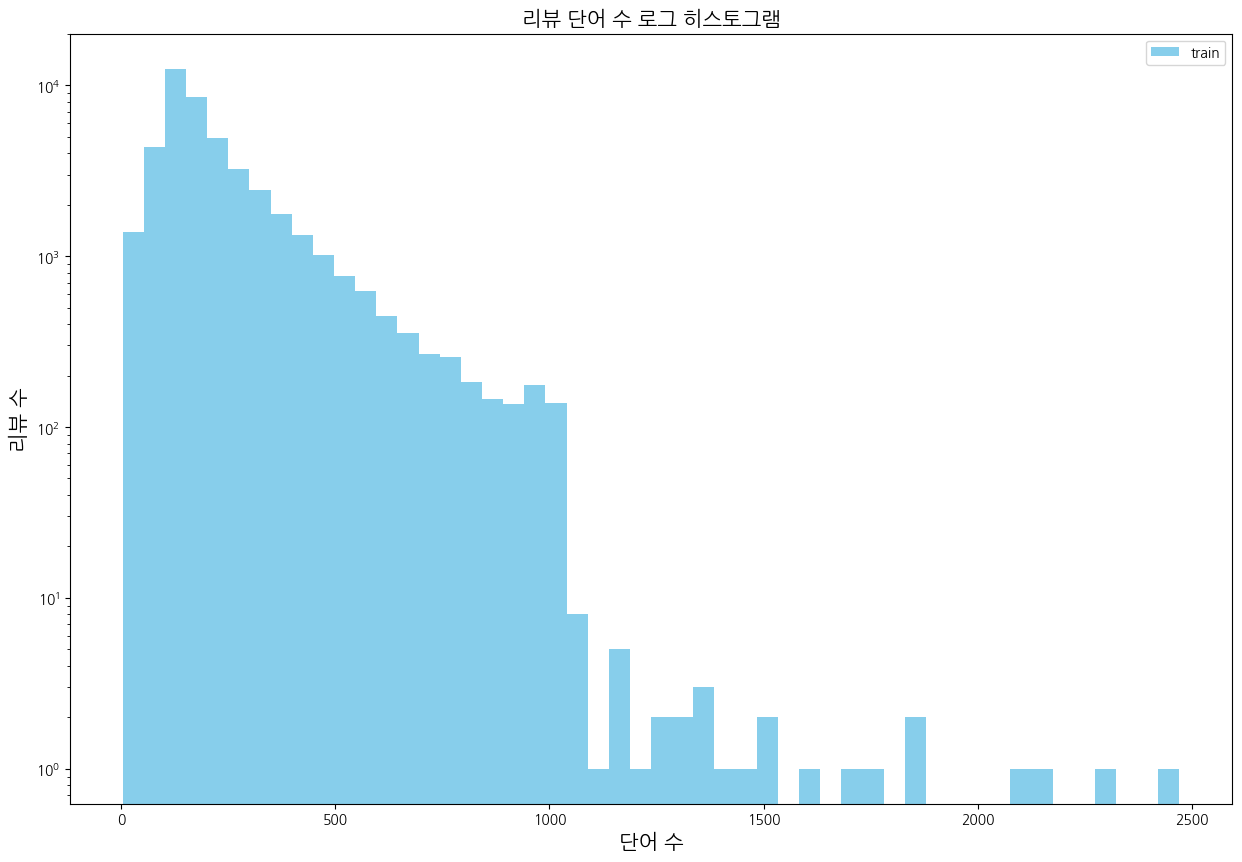

In [156]:
# 문장 길이 분포 시각화
# 로그 히스토그램 : 히스토그램의 Y축을 로그 스케일로 표현한 그래프
# 작은 값과 큰 값의 차이를 더 잘 비교할 수 있음
import matplotlib.pyplot as plt
import koreanize_matplotlib

train_word_counts = train['review'].apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='skyblue', label='train')
plt.title('리뷰 단어 수 로그 히스토그램', fontsize=15)
plt.yscale('log')    # Y축 로그화
plt.legend()
plt.xlabel('단어 수', fontsize=15)
plt.ylabel('리뷰 수', fontsize=15)
plt.show()

In [157]:
# 통곗값 확인
import numpy as np

print('리뷰 길이 최댓값: {}'.format(np.max(train_word_counts)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_word_counts)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 길이 중간값: {}'.format(np.median(train_word_counts)))

리뷰 길이 최댓값: 2470
리뷰 길이 최솟값: 4
리뷰 길이 평균값: 230.68
리뷰 길이 표준편차: 170.78
리뷰 길이 중간값: 173.0


In [158]:
tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in train.lemmatized_review]
test_tokens = [tokenizer.morphs(review) for review in test.lemmatized_review]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>","<unk>"])
token_to_id = {token:idx for idx,token in enumerate(vocab)}
id_to_token = {idx:token for idx,token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))  # 스페셜 토큰 + 5000개의 단어 사전 크기

['<pad>', '<unk>', 'br', 'movie', 'film', 'one', 'like', 'time', 'good', 'character']
5002


In [159]:
# 정수 인코딩 및 패딩
import numpy as np

def pad_sequences(sequences, max_length, pad_value):
    result = list()
    
    for sequence in sequences:
        sequence = sequence[:max_length]
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length
        result.append(padded_sequence)
        
    return np.asarray(result)

In [160]:
unk_id = token_to_id["<unk>"]

train_ids = [[token_to_id.get(token,unk_id) for token in review] for review in train_tokens]
test_ids = [[token_to_id.get(token,unk_id) for token in review] for review in test_tokens]

In [161]:
max_length = 32
pad_id = token_to_id["<pad>"]

train_ids = pad_sequences(train_ids, max_length, pad_id)
test_ids = pad_sequences(test_ids, max_length, pad_id)

print(train_ids[0])
print(test_ids[0])

[ 362   36    4    1   16  391    1    2  229 1827    1  468 4200    1
   12   90 1160    5  356  150    7  227  150   19  931    3   42  752
    1   29  305    9]
[ 617 2086  137    5   49    4   50  410   22    1   36    4  867  741
    6  127   30  505  285  432   15  580   31    1  679   50  432   13
    1    3  259   68]


In [162]:
# 데이터로더 적용 
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ids = torch.tensor(train_ids)
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.sentiment.values, dtype=torch.float32)
test_labels = torch.tensor(test.sentiment.values, dtype=torch.float32)

# 데이터 셋 생성
train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [175]:
# 손실 함수와 최적화 함수 정의
from torch import optim

n_vocab = len(token_to_id)
hidden_dim = 64
embedding_dim = 128
n_layers = 3

In [164]:
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier(n_vocab=n_vocab,
                                hidden_dim=hidden_dim,
                                embedding_dim=embedding_dim,
                                n_layers=n_layers).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(), lr=0.001)

In [165]:
# 모델 학습 및 테스트
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")

In [166]:
def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()
    
    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits) > .5
        corrects.extend(torch.eq(yhat, labels).cpu().tolist())
        
    print(f"Val Loss : {np.mean(losses)}, Val Accuracy {np.mean(corrects)}")

In [167]:
epochs = 5
interval = 500

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6924139857292175
Train Loss 500 : 0.6627299468555374
Train Loss 1000 : 0.6269368512647135
Train Loss 1500 : 0.6002193754669192
Train Loss 2000 : 0.5810589282394111
Train Loss 2500 : 0.5676249193756736
Val Loss : 0.4840096893211523, Val Accuracy 0.7624
Train Loss 0 : 0.5517156720161438
Train Loss 500 : 0.45536004476799463
Train Loss 1000 : 0.4499287078460375
Train Loss 1500 : 0.44458960750196713
Train Loss 2000 : 0.4408668794746938
Train Loss 2500 : 0.4396957211682006
Val Loss : 0.44749646431531387, Val Accuracy 0.785
Train Loss 0 : 0.2662830948829651
Train Loss 500 : 0.37445551948157135
Train Loss 1000 : 0.3792203292771653
Train Loss 1500 : 0.3827566669374049
Train Loss 2000 : 0.3832247760007228
Train Loss 2500 : 0.3826877451012107
Val Loss : 0.44821053295851515, Val Accuracy 0.7922
Train Loss 0 : 0.44973716139793396
Train Loss 500 : 0.32354760166265056
Train Loss 1000 : 0.32685252359056927
Train Loss 1500 : 0.3296373869496572
Train Loss 2000 : 0.33221942058455817
Trai

In [168]:
# 학습된 모델로부터 임베딩 추출
token_to_embedding = dict()
embedding_matrix = classifier.embedding.weight.detach().cpu().numpy()

for word, emb in zip(vocab, embedding_matrix):
    token_to_embedding[word] = emb
    
token = vocab[1000]
print(token, token_to_embedding[token])

building [ 0.64918184 -1.3780289   1.674568   -1.2465303   0.01215244 -0.9541414
  1.2753053  -1.1939234  -1.6198449   1.1771425  -0.24742928  1.1931523
  1.4427627  -0.5720823   1.2240255   0.29838872  0.3916931  -0.1336506
 -0.7794232   0.26330975 -1.4078219  -0.8493043   0.9685048   0.8900418
  0.5190609   0.5220819   1.9609727   0.85435987  0.9957031  -0.14694752
 -0.27688316  2.0464358   1.829574    0.8794156  -1.3891367  -0.42756382
  0.56110793 -0.9684921  -0.43309683 -1.079821    0.5032233   1.3833418
 -0.42230132  1.0817661   0.66635793 -0.27711803  1.0188215   0.14264132
 -0.8184821   1.851171   -0.07132146 -0.09535058  0.30393103 -0.676573
  0.80934167 -1.372588   -1.7284273   0.27331942 -2.5869143   0.08200476
 -0.47580796 -1.1907473   0.16114709  0.32386094 -0.7167921  -0.5397502
  0.8276     -1.8781598   0.5470041  -0.9841865  -0.92830014  0.24929483
 -3.1646106   1.7707177  -1.35097    -0.03376483  0.58709157 -1.220385
 -1.4404488  -1.9797202  -0.13870804 -0.25605565  1.

In [169]:
from gensim.models import Word2Vec
import gensim

In [178]:
# 임베딩 모델 학습 (FastText)
fasttext = gensim.models.FastText(
    sentences=train_tokens, # 학습에 사용할 문장의 리스트를 직접 제공 (None일 경우 corpus_file 사용)
    vector_size=128,        # 단어 임베딩 벡터의 차원 (벡터의 크기)
    window=5,               # 주변 단어를 고려하는 윈도우 크기 (양쪽에서 총 단어 수)
    min_count=5,            # 최소 등장 횟수 (이 값보다 적게 등장한 단어는 무시)
    sg=1,                   # Skip-gram(1) 또는 CBOW(0) 모델 선택 (기본값은 CBOW)
    max_final_vocab=None,   # 최종 생성되는 vocabulary의 최대 크기 (None이면 제한 없음)
    epochs=5,               # 학습 데이터셋을 반복할 횟수 (Epoch 수)
    min_n=2,                # 단어 서브워드(subword) 최소 길이 (FastText의 핵심)
    max_n=6                 # 단어 서브워드(subword) 최대 길이)
)

# 모델 저장
word2vec.save('./models/improved_word2vec.model')

In [179]:
# 사전 학습된 모델로 임베딩 계층 초기화
from gensim.models import Word2Vec


word2vec = Word2Vec.load('./models/improved_word2vec.model')
init_embeddings = np.zeros((n_vocab, embedding_dim))

for index,token in id_to_token.items(): 
    if token not in ["<pad>","<unk>"]: 
        init_embeddings[index] = word2vec.wv[token]

embedding_layer = nn.Embedding.from_pretrained(torch.tensor(init_embeddings, dtype=torch.float32))

In [180]:
# 사전 학습된 임베딩 계층 적용하도록 수정된 클래스
class SentenceClassifier(nn.Module):
    
    def __init__(self, 
                 n_vocab,             # n_vocab: 단어 사전(vocabulary)의 크기 (총 단어 수)
                 hidden_dim,          # hidden_dim: RNN의 은닉 상태(hidden state)의 크기 (출력 차원)
                 embedding_dim,       # embedding_dim: 단어 임베딩(embedding) 벡터의 차원 (특징 수)
                 n_layers,            # n_layers: RNN 층의 개수 (몇 층으로 쌓을지 결정)
                 dropout=0.5,         # dropout: 드롭아웃(dropout) 비율 (과적합 방지를 위한 노드 무작위 비활성화 비율)
                 bidirectional=True,  # bidirectional: 양방향 RNN 여부 (True: 양방향, False: 단방향)
                 pretrained_embedding=None, # 사전 학습된 임베딩 모델을 사용할 건지 여부
                 model_type="lstm"):
        super().__init__()
        
        
        # 사전 학습 임베딩 여부에 따라....
        if pretrained_embedding is not None:
            self.embedding = nn.Embedding.from_pretrained(torch.tensor(pretrained_embedding, dtype=torch.float32))
            
        else:
            self.embedding = nn.Embedding(num_embedding=n_vocab,
                                          embedding_dim=embedding_dim,
                                          padding_idx=0)
        
        
        # 모델 타입에 따라....
        if model_type == 'rnn':
            self.model = nn.RNN(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
            
            
        elif model_type == 'lstm':
            self.model = nn.LSTM(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                num_layers=n_layers,
                                bidirectional=bidirectional,
                                dropout=dropout,
                                batch_first=True)
        
        
        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim,1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:,-1,:]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [181]:
# 사전 학습된 임베딩 모델을 사용한 모델 학습
classifier = SentenceClassifier(n_vocab=n_vocab,
                                hidden_dim=hidden_dim,
                                embedding_dim=embedding_dim,
                                n_layers=n_layers,
                                pretrained_embedding=init_embeddings).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.RMSprop(classifier.parameters(),lr=0.001)
epochs = 5
interval = 500

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6925681829452515
Train Loss 500 : 0.6604017206651722
Train Loss 1000 : 0.6062167989653903
Train Loss 1500 : 0.5747133854982617
Train Loss 2000 : 0.5545790766192221
Train Loss 2500 : 0.5394956031259371
Val Loss : 0.470971894054748, Val Accuracy 0.7822
Train Loss 0 : 0.44274455308914185
Train Loss 500 : 0.46162992742604125
Train Loss 1000 : 0.45500733693698786
Train Loss 1500 : 0.4561573984541947
Train Loss 2000 : 0.45684775986384296
Train Loss 2500 : 0.45429567472546734
Val Loss : 0.4473893191820136, Val Accuracy 0.7988
Train Loss 0 : 0.533024787902832
Train Loss 500 : 0.43434389078331564
Train Loss 1000 : 0.43385653555035947
Train Loss 1500 : 0.4354396313528154
Train Loss 2000 : 0.4339558633564711
Train Loss 2500 : 0.43353980448080603
Val Loss : 0.45331765073366437, Val Accuracy 0.7904
Train Loss 0 : 0.3766176104545593
Train Loss 500 : 0.41527149769776833
Train Loss 1000 : 0.4190259544061614
Train Loss 1500 : 0.42011804127200775
Train Loss 2000 : 0.4203022686705954
Tra